<a href="https://colab.research.google.com/github/MichaelJP-DS/Pipeline_Accident_Costs_Analysis/blob/main/Predictive_Models_for_Pipeline_Accident_Costs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Unit 2 Final Project Notebook

- Predict all costs from a pipeline accident including all catastrophic loss data points (Regression)

- Predict all costs from a pipeline accident limiting target variable losses to $10M or less (Regression)

#Initial Module Questions

- Y Variable - All Costs (Regresssion Models)

#Train/Val Split

- Using the Date/Time for splitting

#Model Types

- Regression
  - Ridge
  - Random Forest Regressor
  - XGBoost Regressor



#Mount Drive & List Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls

gdrive	sample_data


#Tools

In [519]:
    !pip install category_encoders==2.*

In [520]:
#Libraries
import pandas as pd
import numpy as np

#Pipeline
from sklearn.pipeline import make_pipeline

#metrics
from sklearn.metrics import mean_absolute_error, r2_score

#encoders
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

#ML
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

#CV Tuning Methods
from sklearn.model_selection import RandomizedSearchCV

#Boosters
from sklearn.ensemble import GradientBoostingRegressor

#Permutation
from sklearn.inspection import permutation_importance

#Visualizations
import matplotlib.pyplot as plt


#Prebuilt Functions

In [521]:
#There is no Liquid Subtype for Crude Oil.  All Crude was given a NaN Value
#For many primary liquids there is a subtype.  Create a function to assist in keeping the subtype column

def liquid(change):
  return str(change).replace('0', 'CRUDE OIL')

#WRANGLE with no alteration for loss costs over $10M

In [522]:
def regwrangle(filepath):
  
  #Read in CSV, Parse Accident/Date Time and set as index.
  df = pd.read_csv(filepath, parse_dates=['Accident Date/Time'], index_col=['Accident Date/Time'])

  #Drop Columns with high NaN counts...These colums initally represented with near 90% plus in NaN values
  df.drop(columns=['Operator Employee Injuries',
       'Operator Contractor Injuries', 'Emergency Responder Injuries',
       'Other Injuries', 'Public Injuries', 'All Injuries',
       'Operator Employee Fatalities', 'Operator Contractor Fatalities',
       'Emergency Responder Fatalities', 'Other Fatalities',
       'Public Fatalities', 'All Fatalities', 'Liquid Name'], inplace=True)
  
  #Crude Oil has no subtype/but plenty of good subtypes impute all NaN's with Crude Save SubType Col
  #parameters showed column had negative impact on prediction.  Eliminated as it always scored low in permutation testing.
  #df['Liquid Subtype'] = df['Liquid Subtype'].fillna(0).apply(liquid)

  #For loop to drop High Cardinailaty Object Columns
  Threshold = 350
  drop_hc_cols = [col for col in df.select_dtypes('object').columns
                  if df[col].nunique() > Threshold]
  df.drop(columns=drop_hc_cols, inplace=True)

  #Drop Dupe'ish' columns accident county, Operator ID#
  df.drop(columns=['Operator ID', 'Report Number','Supplemental Number'], inplace=True)

  #FEATURE ENGINEERING considerations
  #Need to eliminate dollar cost columns b/c they are too leaky  
  #I like the idea of knowing whether there will be a cost incurred though  
  #In my opinion, an out of the gate assesment could be made regarding whether a cost will be incurred 
  #Emergency Response/Environmental Remediation/Lost Commodity/Property Damage 
  #An immediate on-site assesment would tell us Yes or No.
  df.loc[df['Emergency Response Costs'] >= 1, 'Emergency Response'] = 1
  df.loc[df['Emergency Response Costs'] == 0, 'Emergency Response'] = 0
  df.drop(columns='Emergency Response Costs', inplace=True)

  df.loc[df['Environmental Remediation Costs'] >= 1, 'Environmental Remediation'] = 1
  df.loc[df['Environmental Remediation Costs'] == 0, 'Environmental Remediation'] = 0
  df.drop(columns='Environmental Remediation Costs', inplace=True)

  df.loc[df['Lost Commodity Costs'] >= 1, 'Lost Commodity'] = 1
  df.loc[df['Lost Commodity Costs'] == 0, 'Lost Commodity'] = 0
  df.drop(columns='Lost Commodity Costs', inplace=True)
  
  df.loc[df['Property Damage Costs'] >= 1, 'Property Damage'] = 1
  df.loc[df['Property Damage Costs'] == 0, 'Property Damage'] = 0
  df.drop(columns='Property Damage Costs', inplace=True)

  #Deleted any additional column reprsenting a calculation of dollar cost. These represent too much possibility for leakage. 
  #I don't know enough about these two columns to say whether an initial assesment could be made.
  df.drop(columns=['Public/Private Property Damage Costs', 'Other Costs'], inplace=True)


  #Drop columns as a result of permutation importantance testing
  df.drop(columns=['Accident Year','Liquid Subtype','Liquid Type','Operator Name','Cause Category', 'Liquid Ignition', 'Pipeline Location', 'Cause Subcategory', 'Accident Latitude', 'Accident Longitude', 'Liquid Explosion', 'Public Evacuations',
  'Accident State', 'Net Loss (Barrels)', 'Intentional Release (Barrels)', 'Environmental Remediation'], inplace=True)

  return df

df_final = regwrangle('database 2.csv')

## Alternate Wrangle with elimination of losses over $10M

In [523]:
def regwranglerev(filepath):
  
  #Read in CSV, Parse Accident/Date Time and set as index.
  df1 = pd.read_csv(filepath, parse_dates=['Accident Date/Time'], index_col=['Accident Date/Time'])

  #Drop Columns with high NaN counts...These colums initally represented with near 90% plus in NaN values
  df1.drop(columns=['Operator Employee Injuries',
       'Operator Contractor Injuries', 'Emergency Responder Injuries',
       'Other Injuries', 'Public Injuries', 'All Injuries',
       'Operator Employee Fatalities', 'Operator Contractor Fatalities',
       'Emergency Responder Fatalities', 'Other Fatalities',
       'Public Fatalities', 'All Fatalities', 'Liquid Name'], inplace=True)
  
  #Crude Oil has no subtype/but plenty of good subtypes impute all NaN's with Crude Save SubType Col
  #parameters showed column had negative impact on prediction.  Eliminated as it always scored low in permutation testing.
  df1['Liquid Subtype'] = df1['Liquid Subtype'].fillna(0).apply(liquid)

  #For loop to drop High Cardinailaty Object Columns
  Threshold = 350
  drop_hc_cols = [col for col in df1.select_dtypes('object').columns
                  if df1[col].nunique() > Threshold]
  df1.drop(columns=drop_hc_cols, inplace=True)

  #Drop Dupe'ish' columns accident county, Operator ID#
  df1.drop(columns=['Operator ID', 'Report Number','Supplemental Number'], inplace=True)

  #FEATURE ENGINEERING considerations
  #Need to eliminate dollar cost columns b/c they are too leaky  
  #I like the idea of knowing whether there will be a cost incurred though  
  #In my opinion, an out of the gate assesment could be made regarding whether a cost will be incurred 
  #Emergency Response/Environmental Remediation/Lost Commodity/Property Damage 
  #An immediate on-site assesment would tell us Yes or No.
  df1.loc[df1['Emergency Response Costs'] >= 1, 'Emergency Response'] = 1
  df1.loc[df1['Emergency Response Costs'] == 0, 'Emergency Response'] = 0
  df1.drop(columns='Emergency Response Costs', inplace=True)

  df1.loc[df1['Environmental Remediation Costs'] >= 1, 'Environmental Remediation'] = 1
  df1.loc[df1['Environmental Remediation Costs'] == 0, 'Environmental Remediation'] = 0
  df1.drop(columns='Environmental Remediation Costs', inplace=True)

  df1.loc[df1['Lost Commodity Costs'] >= 1, 'Lost Commodity'] = 1
  df1.loc[df1['Lost Commodity Costs'] == 0, 'Lost Commodity'] = 0
  df1.drop(columns='Lost Commodity Costs', inplace=True)
  
  df1.loc[df1['Property Damage Costs'] >= 1, 'Property Damage'] = 1
  df1.loc[df1['Property Damage Costs'] == 0, 'Property Damage'] = 0
  df1.drop(columns='Property Damage Costs', inplace=True)

  #Deleted any additional column reprsenting a calculation of dollar cost. These represent too much possibility for leakage. 
  #I don't know enough about these two columns to say whether an initial assesment could be made.
  df1.drop(columns=['Public/Private Property Damage Costs', 'Other Costs'], inplace=True)

  #drop all rows where total costs are in excess of $10,000,000.  
  #This resulted in the loss of on 21 columns.
  df1.drop(df1[df1['All Costs'] > 10000000].index, inplace=True)

  #Drop columns as a result of permutation importantance testing
  df1.drop(columns=['Accident Year','Cause Category', 'Cause Subcategory', 'Liquid Recovery (Barrels)', 'Public Evacuations','Accident State', 'Pipeline Type', 'Pipeline Location', 'Environmental Remediation',
                    'Lost Commodity', 'Liquid Ignition', 'Pipeline Shutdown', 'Liquid Explosion', 'Operator Name', 'Accident Latitude', 'Intentional Release (Barrels)'], inplace=True)

  return df1

df1_final = regwranglerev('database 2.csv')

#EDA - Exploratory Data Analysis

I used this space to conduct a variety of tests and information gathering techniques. I later brought some of the code into the wrangle function.  As this is just a brainstorming section, I deleted the cells.  It makes the rest of the notebook easier to follow.

#Split Data into Target and Feature Data Frames

##Regression - Target and Feature All Costs

In [524]:
target = 	'All Costs'

y_a = df_final[target]

X_a = df_final.drop(columns=target)


##Regression - Target and Feature $10M or Less

In [525]:
target = 	'All Costs'

y_a1 = df1_final[target]

X_a1 = df1_final.drop(columns=target)

##Create Mask for Train/Val/Test

### All Costs

In [526]:
cutoff1 = '2015-05-12 09:14:00'
cutoff2 = '2016-04-28 10:45:00'

mask1 = df_final.index <= cutoff1

mask2 = ((df_final.index > cutoff1) & (df_final.index < cutoff2))

mask3 = df_final.index >= cutoff2


### $10M or Less

In [527]:
cutoff1 = '2015-05-12 09:14:00'
cutoff2 = '2016-04-28 10:45:00'

mask11 = df1_final.index <= cutoff1

mask22 = ((df1_final.index > cutoff1) & (df1_final.index < cutoff2))

mask33 = df1_final.index >= cutoff2

#Regression Train/Val/Test Split

### All Costs

In [528]:
X_a_train, y_a_train = X_a[mask1], y_a[mask1]

X_a_val, y_a_val = X_a[mask2], y_a[mask2]

X_a_test, y_a_test = X_a[mask3], y_a[mask3]

### $10M or Less

In [529]:
X_a1_train, y_a1_train = X_a1[mask11], y_a1[mask11]

X_a1_val, y_a1_val = X_a1[mask22], y_a1[mask22]

X_a1_test, y_a1_test = X_a1[mask33], y_a1[mask33]

###Baseline All Costs Rows

In [530]:
average_rating = y_a_train.mean()

baseline_pred = [average_rating] * len(y_a_val)

print('Regression Baseline', mean_absolute_error(y_a_val, baseline_pred))

Regression Baseline 1255588.9803684002


###Baseline for model with $10M or Less

In [387]:
average_rating = y_a1_train.mean()

baseline_pred = [average_rating] * len(y_a1_val)

print('Regression Baseline $10M or Less', mean_absolute_error(y_a1_val, baseline_pred))

Regression Baseline $10M or Less 313592.21891102876


#Build Models & Tune -- Regression Section

##Hyper Parameter Tuning

###Random Forest Regressor Hyperparameter Tuning

In [477]:
#Stopped tuning and focused on Gradient Booster
clf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestRegressor(),
)

rfr_param_grid = {'simpleimputer__strategy': ['mean', 'median'],
                 'randomforestregressor__max_depth': range(2, 40, 2),
                 'randomforestregressor__n_estimators': range(25, 200, 25),
                 'randomforestregressor__min_samples_split': range(1, 10, 1),
                 'randomforestregressor__max_leaf_nodes': range(1, 30, 1),
                 'randomforestregressor__max_features': ['auto', 'log2', 'sqrt'],
                 'randomforestregressor__min_samples_leaf': range(1, 10, 1)
                 }

model_rfrr = RandomizedSearchCV(
    clf,
    param_distributions = rfr_param_grid,
    n_jobs=-1,
    cv=5,
    n_iter=7,
    verbose=1
)

model_rfrr.fit(X_a_train, y_a_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    4.3s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [478]:
#check best parameters
model_rfrr.best_params_

{'randomforestregressor__max_depth': 24,
 'randomforestregressor__max_features': 'log2',
 'randomforestregressor__max_leaf_nodes': 25,
 'randomforestregressor__min_samples_leaf': 9,
 'randomforestregressor__min_samples_split': 7,
 'randomforestregressor__n_estimators': 125,
 'simpleimputer__strategy': 'median'}

###Gradient Boosting Regressor Hyperparameter Tuning

In [471]:
clf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    GradientBoostingRegressor(),
)

gbr_param_grid = {'simpleimputer__strategy': ['mean', 'median'],
                 'gradientboostingregressor__max_depth': range(2, 40, 2),
                 'gradientboostingregressor__n_estimators': range(25, 200, 25),
                 'gradientboostingregressor__loss': ['squared_error', 'ls', 'absolute_error', 'lad', 'huber', 'quantile'],
                 'gradientboostingregressor__min_samples_split': range(1, 10, 1),
                 'gradientboostingregressor__max_leaf_nodes': range(1, 30, 1)
                 }

model_gbrr = RandomizedSearchCV(
    clf,
    param_distributions = gbr_param_grid,
    n_jobs=-1,
    cv=10,
    n_iter=7,
    verbose=1
)

model_gbrr.fit(X_a_train, y_a_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.6s finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,

In [472]:
#check best parameters
model_gbrr.best_params_

{'gradientboostingregressor__loss': 'lad',
 'gradientboostingregressor__max_depth': 10,
 'gradientboostingregressor__max_leaf_nodes': 4,
 'gradientboostingregressor__min_samples_split': 6,
 'gradientboostingregressor__n_estimators': 75,
 'simpleimputer__strategy': 'mean'}

###Gradient Boosting Regressor Hyperparameter Tuning $10M or Less

In [305]:
clf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    GradientBoostingRegressor(),
)

gbr_param_grid1 = {'simpleimputer__strategy': ['mean', 'median'],
                 'gradientboostingregressor__max_depth': range(2, 40, 2),
                 'gradientboostingregressor__n_estimators': range(25, 200, 25),
                 'gradientboostingregressor__loss': ['squared_error', 'ls', 'absolute_error', 'lad', 'huber', 'quantile'],
                 'gradientboostingregressor__min_samples_split': range(1, 10, 1),
                 'gradientboostingregressor__max_leaf_nodes': range(1, 30, 1)
                 }

model_gbrr1 = RandomizedSearchCV(
    clf,
    param_distributions = gbr_param_grid1,
    n_jobs=-1,
    cv=10,
    n_iter=7,
    verbose=1
)

model_gbrr1.fit(X_a1_train, y_a1_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.7s finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,

In [306]:
#check best parameters
model_gbrr1.best_params_

{'gradientboostingregressor__loss': 'huber',
 'gradientboostingregressor__max_depth': 6,
 'gradientboostingregressor__max_leaf_nodes': 8,
 'gradientboostingregressor__min_samples_split': 2,
 'gradientboostingregressor__n_estimators': 175,
 'simpleimputer__strategy': 'median'}

##Regression Models

### Simple Ridge Regression Model

In [388]:
model_ridge = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    Ridge(alpha=1000, solver='auto')
)

model_ridge.fit(X_a_train, y_a_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Pipeline Type', 'Pipeline Shutdown'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ridge',
                 Ridge(alpha=1000, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

###Random Forest Regressor Model All Costs

 ## Best Hyperparameters RFR
 - randomforestregressor__max_depth': 24,
 - randomforestregressor__max_features': 'log2',
 - randomforestregressor__max_leaf_nodes': 25,
 - randomforestregressor__min_samples_leaf': 9,
 - randomforestregressor__min_samples_split': 7,
 - randomforestregressor__n_estimators': 125,
 - simpleimputer__strategy': 'median'

In [479]:
model_rfr = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor(n_estimators=125, max_depth=24, max_leaf_nodes=25, min_samples_leaf=9, min_samples_split=7, max_features='log2')
)

model_rfr.fit(X_a_train, y_a_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Pipeline Type', 'Pipeline Shutdown'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Pipeline Type',
                                          'data_type': dtype('O'),
                                          'mapping': ABOVEGROUND        1
UNDERGROUND        2
TANK               3
NaN                4
TRANSITION AREA    5
dtype: int64},
                                         {'col': 'Pipeline Shutdown',
                                          'data_type': dtype('O'),
                                          'mappin...
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=24,
                                       max_features='log2', max_leaf_nodes=25,
                 

##Best Hyperparameters GBR All Costs
 - gradientboostingregressor__loss': 'lad',
 - gradientboostingregressor__max_depth': 10,
 - gradientboostingregressor__max_leaf_nodes': 4,
 - gradientboostingregressor__min_samples_split': 6,
 - gradientboostingregressor__n_estimators': 75,
 - simpleimputer__strategy': 'mean'

###Gradient Booster Regressor Model All Loss Costs

In [473]:
model_gbr = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    GradientBoostingRegressor(n_estimators=75, max_depth=10, loss='lad', min_samples_split=6, max_leaf_nodes=4)
)

model_gbr.fit(X_a_train, y_a_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Pipeline Type', 'Pipeline Shutdown'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Pipeline Type',
                                          'data_type': dtype('O'),
                                          'mapping': ABOVEGROUND        1
UNDERGROUND        2
TANK               3
NaN                4
TRANSITION AREA    5
dtype: int64},
                                         {'col': 'Pipeline Shutdown',
                                          'data_type': dtype('O'),
                                          'mappin...
                                           learning_rate=0.1, loss='lad',
                                           max_depth=10, max_features=None,
                                           max_leaf_nodes=4,
                         

##Best Parameters - GBR $10M or Less
 - gradientboostingregressor__loss': 'huber',
 - gradientboostingregressor__max_depth': 6,
 - gradientboostingregressor__max_leaf_nodes': 8,
 - gradientboostingregressor__min_samples_split': 2,
 - gradientboostingregressor__n_estimators': 175,
 - simpleimputer__strategy': 'median'
 - tuned a bit more after the CV params

##Gradient Boosting Regression $10M or Less

In [508]:
model_gbr1 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    StandardScaler(),
    GradientBoostingRegressor(n_estimators=136, max_depth=8, loss='lad', min_samples_split=2, max_leaf_nodes=8)
)

model_gbr1.fit(X_a1_train, y_a1_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Liquid Type', 'Liquid Subtype'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Liquid Type',
                                          'data_type': dtype('O'),
                                          'mapping': HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS              1
CRUDE OIL                                               2
REFINED AND/OR PETROLEUM PRODUCT (NON-HVL), LIQUID      3
CO2 (CARBON DIOXIDE)                                    4
BIOFUEL / ALTERN...
                                           learning_rate=0.1, loss='lad',
                                           max_depth=8, max_features=None,
                                           max_leaf_nodes=8,
                                           min_impurity_decrease=0.0,
                     

#Check Metrics - Regression Models
- Use MAE to check model metrics
- R^2 more informational

###Ridge MAE and r^2



In [392]:
print('Ridge Train', mean_absolute_error(y_a_train, model_ridge.predict(X_a_train)))
print('Ridge Val', mean_absolute_error(y_a_val, model_ridge.predict(X_a_val)))

Ridge Train 1666227.81190526
Ridge Val 1346561.2511168239


In [393]:
print('Ridge Train', r2_score(y_a_train, model_ridge.predict(X_a_train)))
print('Ridge Val', r2_score(y_a_val, model_ridge.predict(X_a_val)))

Ridge Train 0.4406177910953095
Ridge Val 0.04064708373681247


###Random Forest Regressor MAE and r^2 score

In [480]:
print('Random Forest Regressor Train', mean_absolute_error(y_a_train, model_rfr.predict(X_a_train)))
print('Random Forest Regressor Val', mean_absolute_error(y_a_val, model_rfr.predict(X_a_val)))

Random Forest Regressor Train 1281148.342158059
Random Forest Regressor Val 883922.9388849566


In [481]:
print('Random Forest Regressor Train', r2_score(y_a_train, model_rfr.predict(X_a_train)))
print('Random Forest Regressor Val', r2_score(y_a_val, model_rfr.predict(X_a_val)))

Random Forest Regressor Train 0.13894237777792373
Random Forest Regressor Val 0.013976484990089189


###Gradient Booster MAE and r^2 score

In [482]:
print('Gradient Booster Regressor Train', mean_absolute_error(y_a_train, model_gbr.predict(X_a_train)))
print('Gradient Booster Regressor Val', mean_absolute_error(y_a_val, model_gbr.predict(X_a_val)))

Gradient Booster Regressor Train 865816.6951960014
Gradient Booster Regressor Val 563825.6915961546


In [483]:
print('Gradient Booster Regressor Train', r2_score(y_a_train, model_gbr.predict(X_a_train)))
print('Gradient Booster Regressor Val', r2_score(y_a_val, model_gbr.predict(X_a_val)))

Gradient Booster Regressor Train 0.011719043380432503
Gradient Booster Regressor Val 0.022651741312511686


##Gradient Booster MAE for Costs $10M or less

In [509]:
print('Gradient Booster Regressor Train', mean_absolute_error(y_a1_train, model_gbr1.predict(X_a1_train)))
print('Gradient Booster Regressor Val', mean_absolute_error(y_a1_val, model_gbr1.predict(X_a1_val)))

Gradient Booster Regressor Train 162510.3029332463
Gradient Booster Regressor Val 170656.16578246967


#MAE Test including All Costs

In [476]:
print('Gradient Booster Regressor Train', mean_absolute_error(y_a_test, model_gbr.predict(X_a_test)))

Gradient Booster Regressor Train 411679.6785112489


#MAE Test for Costs less than $10M

In [510]:
print('Gradient Booster Regressor Train', mean_absolute_error(y_a1_test, model_gbr1.predict(X_a1_test)))

Gradient Booster Regressor Train 179321.59870890947


#Analyze and Improve Feature Importances with Permutation - GBR Models Only


##All Costs

In [511]:
#establish importances
perm_imp = permutation_importance(model_gbr, X_a_val, y_a_val, n_jobs=-1)

perm_imp

{'importances': array([[ 2.82623256e-04,  2.45836331e-03,  1.79848603e-04,
          2.72579406e-03,  3.11730552e-04],
        [ 1.17288739e-02,  1.18366625e-02,  1.18601202e-02,
          9.12285450e-03,  1.08472467e-02],
        [ 1.68227806e-02,  1.89935882e-02,  1.91184134e-02,
          1.65738020e-02,  1.90035368e-02],
        [-9.50409025e-05,  3.16883270e-03, -4.87069081e-05,
          3.11887850e-03, -4.93994633e-05],
        [ 1.51540182e-02,  1.49486337e-02,  3.39788181e-04,
         -8.57683066e-05, -1.50374749e-04],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 1.06337551e-04,  5.97205819e-03,  5.62148342e-05,
          9.69739948e-05,  1.80610432e-04]]),
 'importances_mean': array([0.00119167, 0.01107915, 0.01810242, 0.00121891, 0.00604126,
        0.        , 0.00128244]),
 'importances_std': array([0.00114739, 0.00104754, 0.00115001, 0.00157188, 0.0073589 ,
        0.        , 0.00234515])}

In [512]:
#create dictionary for dataframe
data = {'imp_mean': perm_imp['importances_mean']}

In [513]:
#create dataframe and print mean importances
importances = pd.DataFrame(data, index=X_a_val.columns).sort_values(by='imp_mean', ascending=False)

importances

,imp_mean
Liquid Recovery (Barrels),0.018102
Unintentional Release (Barrels),0.011079
Emergency Response,0.006041
Property Damage,0.001282
Pipeline Shutdown,0.001219
Pipeline Type,0.001192
Lost Commodity,0.000000


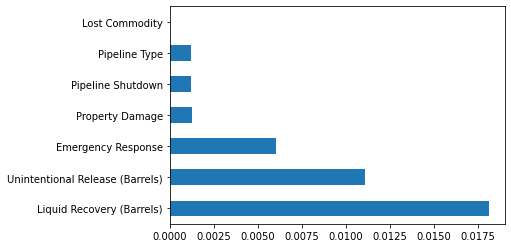

In [514]:
#visualize with bar chart
importances['imp_mean'].head(10).plot(kind='barh');

## Repeat for $10M or Less


In [515]:
perm_imp1 = permutation_importance(model_gbr1, X_a1_val, y_a1_val, n_jobs=-1)

perm_imp1

{'importances': array([[ 0.00575291,  0.00208192,  0.01416477, -0.00133694,  0.01906092],
        [ 0.04690662,  0.00870847,  0.02962687,  0.03231206,  0.03320462],
        [ 0.07149867,  0.10880154,  0.08416888,  0.16235307,  0.05782589],
        [ 0.21365219,  0.18544938,  0.23807352,  0.19223781,  0.13767587],
        [ 0.14229973,  0.13933155,  0.14884362,  0.13173742,  0.13313704],
        [ 0.01601554,  0.03123718,  0.01497656,  0.01869588,  0.0172934 ],
        [ 0.03501715,  0.02552977,  0.00949383,  0.03236465,  0.01375083]]),
 'importances_mean': array([0.00794472, 0.03015173, 0.09692961, 0.19341775, 0.13906987,
        0.01964371, 0.02323125]),
 'importances_std': array([0.00758399, 0.0122866 , 0.03676912, 0.03339346, 0.00624484,
        0.0059292 , 0.01006185])}

In [516]:
data1 = {'imp_mean1': perm_imp1['importances_mean']}

In [517]:
importances1 = pd.DataFrame(data1, index=X_a1_val.columns).sort_values(by='imp_mean1', ascending=False)

importances1

,imp_mean1
Unintentional Release (Barrels),0.193418
Net Loss (Barrels),0.139070
Accident Longitude,0.096930
Liquid Subtype,0.030152
Property Damage,0.023231
Emergency Response,0.019644
Liquid Type,0.007945


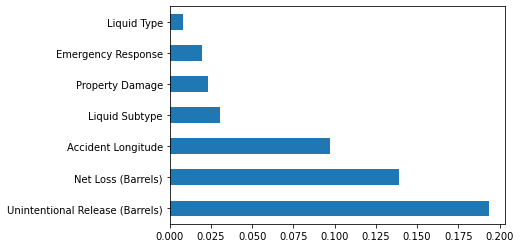

In [518]:
importances1['imp_mean1'].head(10).plot(kind='barh');